In [27]:
import pandas as pd
from math import atan2, degrees
import matplotlib.pyplot as plt

In [4]:
data = pd.read_parquet("G:/My Drive/שנה ב/פרויקט מעבדה/front_head_only_resnet_152__top_20240103T103519.parquet")
data = data.iloc[:,0:13]

In [5]:
def calculate_direction(x_ears, y_ears, x_nose, y_nose):
    delta_x = x_ears - x_nose
    delta_y = y_ears - y_nose
    
    # Calculate direction angle using arctangent
    angle_rad = atan2(delta_y, delta_x)

    # Convert angle from radians to degrees
    direction_angle = degrees(angle_rad)

    # Normalize the angle to be in the range [0, 360)
    direction_angle = (direction_angle + 360) % 360

    return direction_angle

In [6]:
azimuth_angle_lst = []
for i in range(len(data)):
    x_ears = data['mid_ears', 'cam_x'][i]
    y_ears = data['mid_ears', 'cam_y'][i]
    x_nose = data['nose', 'cam_x'][i]
    y_nose = data['nose', 'cam_y'][i]
    azimuth_angle_lst.append(calculate_direction(x_ears, y_ears, x_nose, y_nose))

data['azimuth_angle'] = azimuth_angle_lst

In [26]:
head_direction = data[['azimuth_angle', 'time']]
head_direction

,azimuth_angle,time
,,
0,204.403660,1.704278e+09
1,204.404229,1.704278e+09
2,204.400509,1.704278e+09
3,204.403253,1.704278e+09
4,204.403119,1.704278e+09
...,...,...
18406,206.286587,1.704278e+09
18407,206.290808,1.704278e+09
18408,206.289931,1.704278e+09


In [64]:
head_direction[(head_direction['azimuth_angle'] > 0) & (head_direction['azimuth_angle'] < 90)]

,azimuth_angle,time
,,
250,6.912828,1.704278e+09
251,6.957822,1.704278e+09
252,6.924232,1.704278e+09
253,6.992670,1.704278e+09
254,6.835219,1.704278e+09
...,...,...
15168,4.991260,1.704278e+09
15169,5.899830,1.704278e+09
15170,6.116691,1.704278e+09


In [71]:
head_direction['time'].iloc[0:250].sum() * 10**-3

426069530.40522116

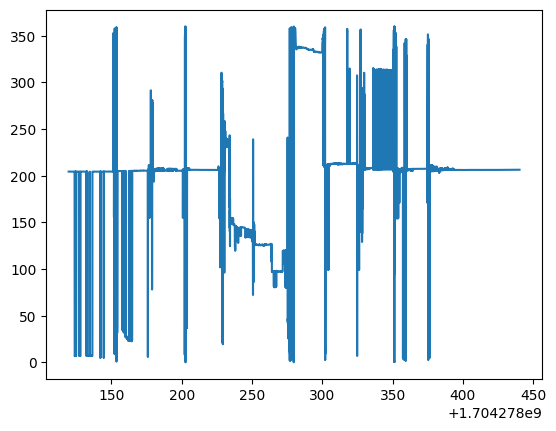

In [78]:
xpoints_h = head_direction['time']
ypoints_h = head_direction['azimuth_angle']
plt.plot(xpoints_h, ypoints_h)
plt.show()

In [80]:
distance_from_screen = data[[('nose', 'cam_x'), ('time', '')]]
distance_from_screen.columns = ['distance', 'time']
distance_from_screen

,distance,time
0,1193.508667,1.704278e+09
1,1193.516113,1.704278e+09
2,1193.454834,1.704278e+09
3,1193.522949,1.704278e+09
4,1193.549683,1.704278e+09
...,...,...
18406,1193.485352,1.704278e+09
18407,1193.500122,1.704278e+09
18408,1193.480591,1.704278e+09
18409,1193.489746,1.704278e+09


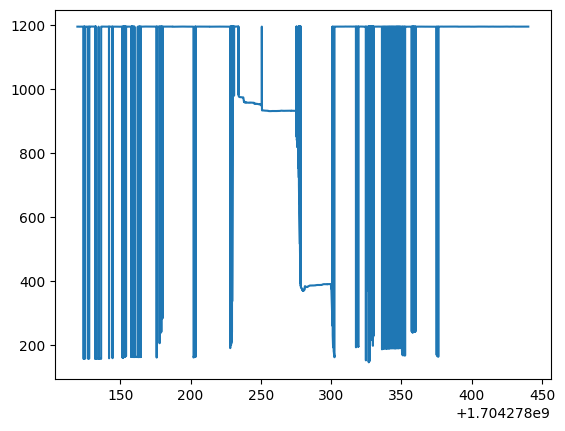

In [82]:
xpoints_d = distance_from_screen['time']
ypoints_d = distance_from_screen['distance']
plt.plot(xpoints_d, ypoints_d)
plt.show()